In [1]:
# Titanic Data Preprocessing & Modeling Pipeline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# 1. INITIAL EXPLORATION

# Load dataset
print("Loading Titanic dataset...")
titanic = sns.load_dataset('titanic')
print(f"Dataset shape: {titanic.shape}")

# Initial exploration
print("\n=== Initial Exploration ===")
print("\nFirst 5 rows:")
print(titanic.head())

print("\nDataset Info:")
titanic.info()

print("\nStatistical Summary:")
print(titanic.describe())

# Check for missing values
print("\n=== Missing Values ===")
missing_values = titanic.isnull().sum()
print(missing_values[missing_values > 0])

# Check data types
print("\n=== Data Types ===")
print(titanic.dtypes)

print("\nColumn names in dataset:")
print(titanic.columns.tolist())

Loading Titanic dataset...
Dataset shape: (891, 15)

=== Initial Exploration ===

First 5 rows:
   survived  pclass     sex   age  sibsp  parch     fare embarked  class  \
0         0       3    male  22.0      1      0   7.2500        S  Third   
1         1       1  female  38.0      1      0  71.2833        C  First   
2         1       3  female  26.0      0      0   7.9250        S  Third   
3         1       1  female  35.0      1      0  53.1000        S  First   
4         0       3    male  35.0      0      0   8.0500        S  Third   

     who  adult_male deck  embark_town alive  alone  
0    man        True  NaN  Southampton    no  False  
1  woman       False    C    Cherbourg   yes  False  
2  woman       False  NaN  Southampton   yes   True  
3  woman       False    C  Southampton   yes  False  
4    man        True  NaN  Southampton    no   True  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 # 


=== Initial Visualizations ===


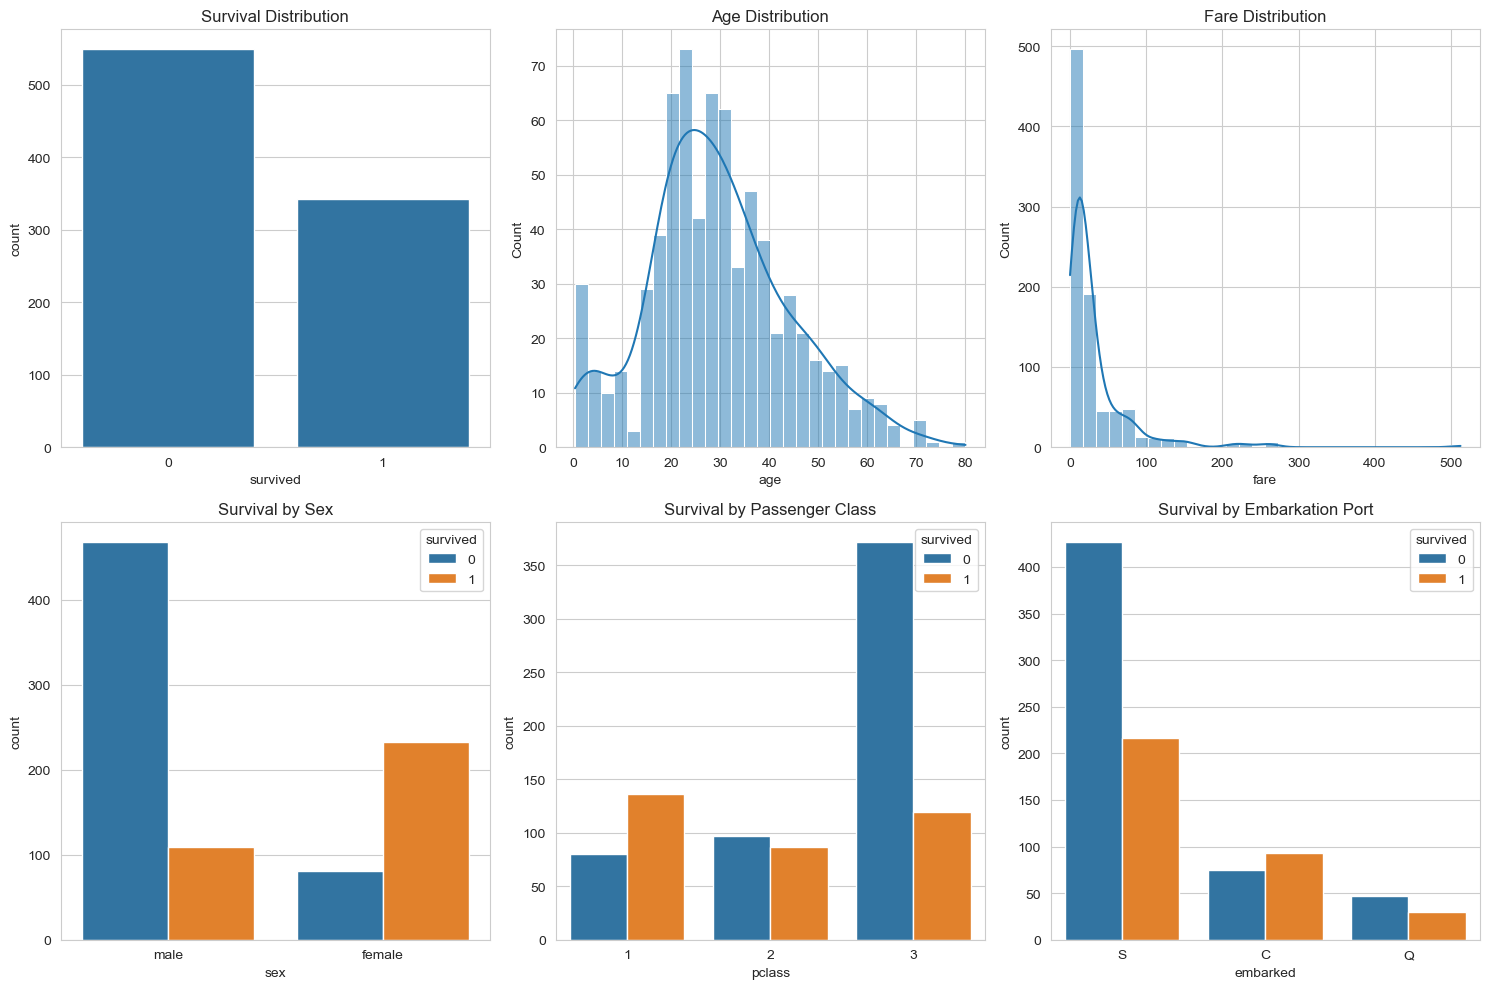

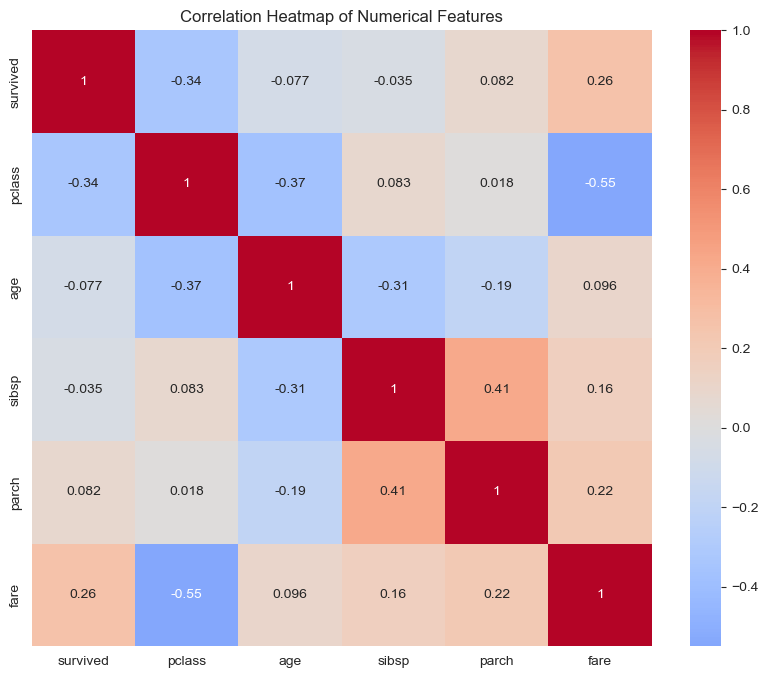

In [2]:
#  VISUALIZATION - Initial EDA
print("\n=== Initial Visualizations ===")
# Set up the visualization style
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. Survival distribution
sns.countplot(x='survived', data=titanic, ax=axes[0, 0])
axes[0, 0].set_title('Survival Distribution')

# 2. Age distribution
sns.histplot(titanic['age'].dropna(), bins=30, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Age Distribution')

# 3. Fare distribution
sns.histplot(titanic['fare'].dropna(), bins=30, kde=True, ax=axes[0, 2])
axes[0, 2].set_title('Fare Distribution')

# 4. Sex vs Survival
sns.countplot(x='sex', hue='survived', data=titanic, ax=axes[1, 0])
axes[1, 0].set_title('Survival by Sex')

# 5. Pclass vs Survival
sns.countplot(x='pclass', hue='survived', data=titanic, ax=axes[1, 1])
axes[1, 1].set_title('Survival by Passenger Class')

# 6. Embarked vs Survival
sns.countplot(x='embarked', hue='survived', data=titanic, ax=axes[1, 2])
axes[1, 2].set_title('Survival by Embarkation Port')

plt.tight_layout()
plt.show()

# Correlation heatmap (numerical features only)
numerical_features = titanic.select_dtypes(include=[np.number])
plt.figure(figsize=(10, 8))
sns.heatmap(numerical_features.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()


In [3]:
# 2. DATA CLEANING
print("\n=== Data Cleaning ===")

# Create a copy for cleaning
df = titanic.copy()

# Drop irrelevant/redundant columns
columns_to_drop = ['deck', 'embark_town', 'alive', 'who', 'adult_male', 'alone']
# Only drop columns that exist
existing_columns_to_drop = [col for col in columns_to_drop if col in df.columns]
df = df.drop(columns=existing_columns_to_drop)
print(f"Dropped columns: {existing_columns_to_drop}")

# Handle missing values
print("\nHandling missing values...")

# Age - fill with median grouped by Pclass and Sex
df['age'] = df.groupby(['pclass', 'sex'])['age'].transform(lambda x: x.fillna(x.median()))

# Embarked - fill with mode (most common value)
df['embarked'] = df['embarked'].fillna(df['embarked'].mode()[0])

# Check remaining missing values
remaining_missing = df.isnull().sum().sum()
print(f"Remaining missing values after cleaning: {remaining_missing}")

# Remove duplicates
initial_rows = len(df)
df = df.drop_duplicates()
final_rows = len(df)
print(f"Removed {initial_rows - final_rows} duplicate rows")


=== Data Cleaning ===
Dropped columns: ['deck', 'embark_town', 'alive', 'who', 'adult_male', 'alone']

Handling missing values...
Remaining missing values after cleaning: 0
Removed 118 duplicate rows


In [5]:
# 3. FEATURE ENGINEERING
print("\n=== Feature Engineering ===")

# Create FamilySize
df['FamilySize'] = df['sibsp'] + df['parch'] + 1
print(f"Created 'FamilySize' feature")

# Create IsAlone
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
print(f"Created 'IsAlone' feature")

# Create AgeGroup
df['AgeGroup'] = pd.cut(df['age'], bins=[0, 12, 18, 35, 60, 100], 
                        labels=['Child', 'Teen', 'Young Adult', 'Adult', 'Senior'])

# Create FareGroup
df['FareGroup'] = pd.qcut(df['fare'], 4, labels=['Low', 'Medium', 'High', 'Very High'])


# Create Title from 'class' and 'sex' (simulated)
df['Title'] = 'Mr'  # Default
df.loc[df['sex'] == 'female', 'Title'] = 'Mrs'
df.loc[(df['sex'] == 'female') & (df['age'] < 18), 'Title'] = 'Miss'
df.loc[(df['sex'] == 'male') & (df['age'] < 18), 'Title'] = 'Master'

# For higher class females in first class
df.loc[(df['class'] == 'First') & (df['sex'] == 'female'), 'Title'] = 'Lady'

print("\nNew features created:")
print(df[['FamilySize', 'IsAlone', 'Title', 'AgeGroup', 'FareGroup']].head())


=== Feature Engineering ===
Created 'FamilySize' feature
Created 'IsAlone' feature

New features created:
   FamilySize  IsAlone Title     AgeGroup  FareGroup
0           2        0    Mr  Young Adult        Low
1           2        0  Lady        Adult  Very High
2           1        1   Mrs  Young Adult        Low
3           2        0  Lady  Young Adult  Very High
4           1        1    Mr  Young Adult        Low


In [6]:
# 4. CATEGORICAL ENCODING
print("\n=== Categorical Encoding ===")

# Create a copy for encoding
df_encoded = df.copy()

# Initialize label encoders
label_encoders = {}

#label encoding for categorical columns
label_encode_cols = ['sex', 'embarked', 'class', 'AgeGroup', 'FareGroup', 'Title']
for col in label_encode_cols:
    if col in df_encoded.columns:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
        label_encoders[col] = le
        print(f"Label encoded: {col}")

print(f"\nFinal dataset shape after encoding: {df_encoded.shape}")


=== Categorical Encoding ===
Label encoded: sex
Label encoded: embarked
Label encoded: class
Label encoded: AgeGroup
Label encoded: FareGroup
Label encoded: Title

Final dataset shape after encoding: (773, 14)


In [7]:
# 5. OUTLIER HANDLING
print("\n=== Outlier Handling ===")

# Function to detect outliers using IQR
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Check for outliers in numerical columns
numerical_cols = ['age', 'fare', 'sibsp', 'parch', 'FamilySize']
for col in numerical_cols:
    if col in df_encoded.columns:
        outliers, lower, upper = detect_outliers_iqr(df_encoded, col)
        print(f"{col}: {len(outliers)} outliers detected (bounds: [{lower:.2f}, {upper:.2f}])")
        
        # Cap outliers instead of removing them
        df_encoded[col] = np.where(df_encoded[col] > upper, upper, df_encoded[col])
        df_encoded[col] = np.where(df_encoded[col] < lower, lower, df_encoded[col])

# Handle skewness in 'fare' using log transformation
if 'fare' in df_encoded.columns:
    df_encoded['fare_log'] = np.log1p(df_encoded['fare'])
    print("Applied log transformation to 'fare'")


=== Outlier Handling ===
age: 13 outliers detected (bounds: [-4.50, 63.50])
fare: 97 outliers detected (bounds: [-31.44, 73.86])
sibsp: 39 outliers detected (bounds: [-1.50, 2.50])
parch: 15 outliers detected (bounds: [-1.50, 2.50])
FamilySize: 83 outliers detected (bounds: [-0.50, 3.50])
Applied log transformation to 'fare'


In [8]:
# 6. SCALING / NORMALIZATION
print("\n=== Feature Scaling ===")

# Separate features and target
X = df_encoded.drop('survived', axis=1)
y = df_encoded['survived']

# Identify numerical columns for scaling
numerical_to_scale = ['age', 'fare', 'sibsp', 'parch', 'FamilySize', 'fare_log']
numerical_to_scale = [col for col in numerical_to_scale if col in X.columns]

print(f"Scaling {len(numerical_to_scale)} numerical features: {numerical_to_scale}")

# Apply StandardScaler
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[numerical_to_scale] = scaler.fit_transform(X[numerical_to_scale])

print("Applied StandardScaler")


=== Feature Scaling ===
Scaling 6 numerical features: ['age', 'fare', 'sibsp', 'parch', 'FamilySize', 'fare_log']
Applied StandardScaler


In [9]:
# 7. TRAIN/TEST SPLIT
print("\n=== Train/Test Split ===")

# Split the data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Features: {X_train.shape[1]}")


=== Train/Test Split ===
Training set: 618 samples
Test set: 155 samples
Features: 14


In [10]:
# 8. MODELING
print("\n" + "="*50)
print("MODEL TRAINING")
print("="*50)

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=500, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5)
}

# Train and evaluate each model
results = {}

for name, model in models.items():
    print(f"\n--- Training {name} ---")
    
    # Train model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Store results
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'predictions': y_pred
    }
    
    print(f"{name} Accuracy: {accuracy:.4f}")


MODEL TRAINING

--- Training Logistic Regression ---
Logistic Regression Accuracy: 0.8065

--- Training K-Nearest Neighbors ---
K-Nearest Neighbors Accuracy: 0.7226


MODEL EVALUATION

=== Model Comparison ===
Logistic Regression: Accuracy = 0.8065
K-Nearest Neighbors: Accuracy = 0.7226

Best Model: Logistic Regression (Accuracy: 0.8065)

Evaluation for Logistic Regression

Confusion Matrix:
[[79 12]
 [18 46]]

Classification Report:
              precision    recall  f1-score   support

        Died       0.81      0.87      0.84        91
    Survived       0.79      0.72      0.75        64

    accuracy                           0.81       155
   macro avg       0.80      0.79      0.80       155
weighted avg       0.81      0.81      0.80       155


Evaluation for K-Nearest Neighbors

Confusion Matrix:
[[75 16]
 [27 37]]

Classification Report:
              precision    recall  f1-score   support

        Died       0.74      0.82      0.78        91
    Survived       0.70      0.58      0.63        64

    accuracy                           0.72       155
   macro avg       0.72      0.70      0.70       155
weighted avg       0.72      0.7

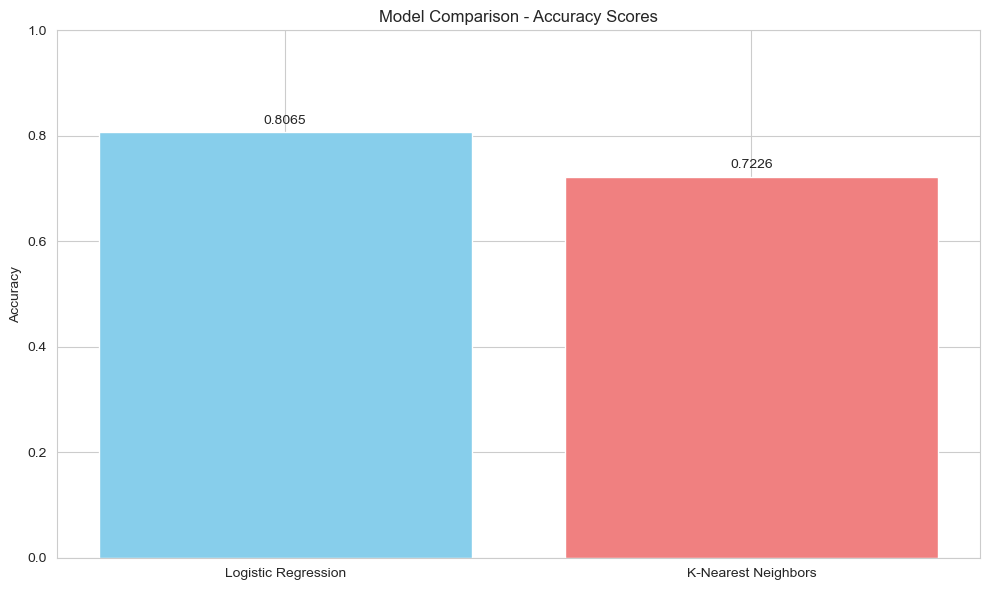

In [11]:
# 9. EVALUATION
print("MODEL EVALUATION")

# Compare models
print("\n=== Model Comparison ===")
for name, result in results.items():
    print(f"{name}: Accuracy = {result['accuracy']:.4f}")

# Determine best model
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
print(f"\nBest Model: {best_model_name} (Accuracy: {results[best_model_name]['accuracy']:.4f})")

# Detailed evaluation for each model
for name, result in results.items():
    print(f"\n{'='*30}")
    print(f"Evaluation for {name}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, result['predictions'])
    print(f"\nConfusion Matrix:\n{cm}")
    
    # Classification Report
    print(f"\nClassification Report:")
    print(classification_report(y_test, result['predictions'], target_names=['Died', 'Survived']))

# Visual comparison
plt.figure(figsize=(10, 6))
model_names = list(results.keys())
accuracies = [results[name]['accuracy'] for name in model_names]

bars = plt.bar(model_names, accuracies, color=['skyblue', 'lightcoral'])
plt.ylabel('Accuracy')
plt.title('Model Comparison - Accuracy Scores')
plt.ylim([0, 1])

# Add accuracy values on top of bars
for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{accuracy:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [14]:
# 11. FINAL SUMMARY
print("PROJECT SUMMARY")

print(f"\n1. Data Preprocessing:")
print(f"   - Initial rows: {len(titanic)}")
print(f"   - Final rows: {len(df_encoded)}")
print(f"   - Features after engineering: {X.shape[1]}")

print(f"\n2. Model Performance:")
for name, result in results.items():
    print(f"   - {name}: {result['accuracy']:.4f} accuracy")

print(f"\n3. Best Model: {best_model_name}")
print(f"   - Accuracy: {results[best_model_name]['accuracy']:.4f}")

print(f"\n4. Key Insights:")
print(f"   - FamilySize and IsAlone were created as new features")
print(f"   - Title was created based on sex, age, and class")
print(f"   - StandardScaler was used for feature scaling")
print(f"  - Stratified split ensured balanced classes in train/test sets")


# Save the processed data
df_encoded.to_csv('titanic_processed.csv', index=False)
print("\nProcessed data saved as 'titanic_processed.csv'")

PROJECT SUMMARY

1. Data Preprocessing:
   - Initial rows: 891
   - Final rows: 773
   - Features after engineering: 14

2. Model Performance:
   - Logistic Regression: 0.8065 accuracy
   - K-Nearest Neighbors: 0.7226 accuracy

3. Best Model: Logistic Regression
   - Accuracy: 0.8065

4. Key Insights:
   - FamilySize and IsAlone were created as new features
   - Title was created based on sex, age, and class
   - StandardScaler was used for feature scaling
  - Stratified split ensured balanced classes in train/test sets

Processed data saved as 'titanic_processed.csv'
